In [1]:
import os
import warnings
from typing import Sequence, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import feature_selection
from sklearn import metrics

In [2]:
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
sample_submission.shape

(36349, 2)

In [4]:
df_test.shape

(36349, 18)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [12]:
orig_data = data.copy()

In [13]:
data.nunique(dropna=False)

education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [14]:
data['default'].value_counts(ascending=True)

1      9372
0    100776
Name: default, dtype: int64

In [15]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [16]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [17]:
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  int64  
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  int64  
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

In [19]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_nan
0,1,29,1,1,0,0,-2.271884,3,3,0,...,3,0,0,0,0,1,0,0,0,0
1,0,39,0,0,5,0,-1.504999,2,3,0,...,2,0,0,0,0,0,0,1,0,0
2,1,50,1,1,0,0,-1.691339,1,3,0,...,2,1,0,0,0,0,0,0,1,0
3,1,56,0,0,0,0,-2.374182,1,2,0,...,2,0,0,0,0,0,0,1,0,0
4,0,38,0,0,0,0,-2.487502,0,6,1,...,2,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,45,0,0,0,0,-1.792064,3,3,0,...,3,0,1,0,0,1,0,0,0,0
110144,1,41,1,1,0,0,-2.058029,1,3,1,...,3,0,1,0,0,0,0,1,0,0
110145,1,31,0,0,0,0,-1.512635,4,6,1,...,1,0,1,0,0,0,0,1,0,0
110146,0,29,0,0,0,1,-1.479334,3,3,0,...,2,0,1,1,0,0,0,1,0,0


In [20]:
class Predictor:
    def __init__(self, feature_columns_list: Sequence[pd.DataFrame], model_params: Optional[dict]=None):
        df = orig_data[['default', 'sample']].copy()
        for feature_columns in feature_columns_list:
            df[feature_columns.columns] = feature_columns
        self.df = df
        self.model_params = {} if model_params is None else model_params
        
    def assess(self):
        train_data = self.df.query('sample == 1').drop(['sample'], axis=1)
        y = train_data['default'].values
        X = train_data.drop(['default'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.model = LogisticRegression(random_state=42, **self.model_params)
        self.model.fit(X_train, y_train)
        y_pred = np.transpose(self.model.predict_proba(X_test))[1]
        classification_report = metrics.classification_report(y_test, y_pred > 0.5, zero_division=0)
        classification_report_dict = metrics.classification_report(y_test, y_pred > 0.5, zero_division=0, output_dict=True)        
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        print(classification_report)
        print(f'     ROC AUC {roc_auc:10.2f}')
        mean_f1 = np.mean((
            classification_report_dict['0']['f1-score'], 
            classification_report_dict['1']['f1-score']
        ))
        return mean_f1, roc_auc
    
    def optimize_model_params(self, max_iter=1000, tol=1e-4) -> dict:
        train_data = self.df.query('sample == 1').drop(['sample'], axis=1)
        y = train_data['default'].values
        X = train_data.drop(['default'], axis=1)
        model = LogisticRegression(random_state=42)
        param_grid = [
            {
                'penalty': ['l1'], 
                'solver': ['liblinear'], 
                'class_weight':[None, 'balanced'], 
                'multi_class': ['auto','ovr'], 
                'max_iter':[max_iter],
                'tol':[tol],
            },
            {
                'penalty': ['l2'], 
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                'class_weight':[None, 'balanced'], 
                'multi_class': ['auto','ovr'], 
                'max_iter':[max_iter],
                'tol':[tol],
            },
            {
                'penalty': ['none'], 
                'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
                'class_weight':[None, 'balanced'], 
                'multi_class': ['auto','ovr'], 
                'max_iter':[max_iter],
                'tol':[tol],
            },
        ]
        gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
        warnings.simplefilter('ignore')
        os.environ["PYTHONWARNINGS"] = "ignore" 
        try:
            gridsearch.fit(X, y)
        finally:
            del os.environ["PYTHONWARNINGS"]
            warnings.resetwarnings()
        self.model_params = gridsearch.best_params_
        return self.model_params
        
        
    def final_predict(self) -> np.ndarray:
        test_data = self.df.query('sample == 0').drop(['sample', 'default'], axis=1)
        y_pred = self.model.predict(test_data)
        return y_pred

In [21]:
Predictor([data]).assess()

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.00      0.00      0.00      1827

    accuracy                           0.88     14760
   macro avg       0.44      0.50      0.47     14760
weighted avg       0.77      0.88      0.82     14760

     ROC AUC       0.55


(0.46701332466688333, 0.5519255464703756)

In [22]:
baseline_params = Predictor([data]).optimize_model_params(max_iter=50, tol=1e-3)

In [23]:
baseline_params['tol'] = 1e-4
baseline_params['max_iter'] = 1000
print('\n'.join(f'{k:15s} {repr(v)}' for k, v in baseline_params.items()))

class_weight    'balanced'
max_iter        1000
multi_class     'auto'
penalty         'l1'
solver          'liblinear'
tol             0.0001


In [24]:
Predictor([data], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760

     ROC AUC       0.74


(0.5586334281187222, 0.7364063731095942)

In [25]:
df_num = orig_data[num_cols].copy()
df_cat = orig_data[cat_cols].copy()
df_bin = orig_data[bin_cols].copy()

In [26]:
df_cat = pd.get_dummies(df_cat, columns=['education'], dummy_na=True)

In [27]:
for column in bin_cols:
    df_bin[column] = le.fit_transform(df_bin[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    df_cat[column] = le.fit_transform(df_cat[column])

In [28]:
Predictor([df_num, df_cat, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760

     ROC AUC       0.74


(0.5581400360000885, 0.7363706113496146)

In [29]:
def show_dists(df: pd.DataFrame):
    for column in df.columns:
        plt.figure(figsize=(15, 4))
        plt.title(column)
        plt.subplot(1, 2, 1)
        df[column].hist(bins=50)
        plt.subplot(1, 2, 2)
        df.boxplot(column)
        plt.show()        

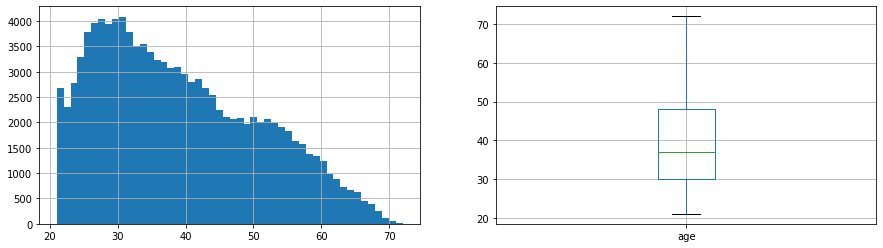

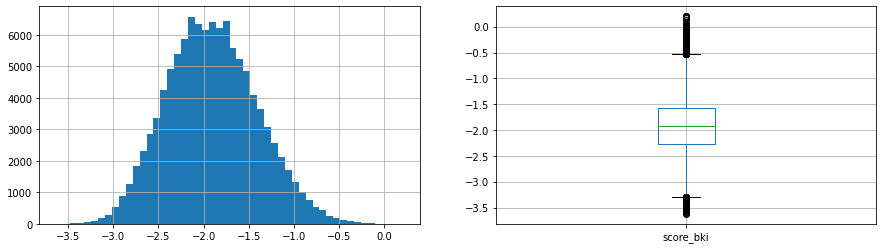

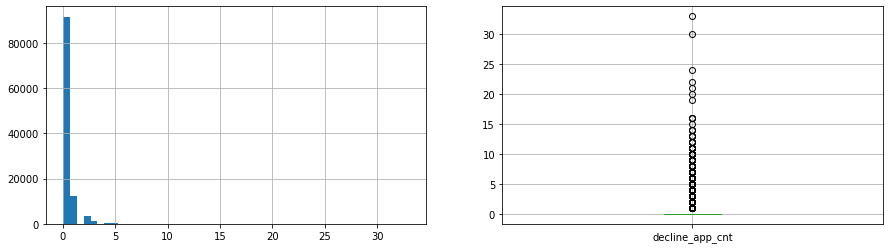

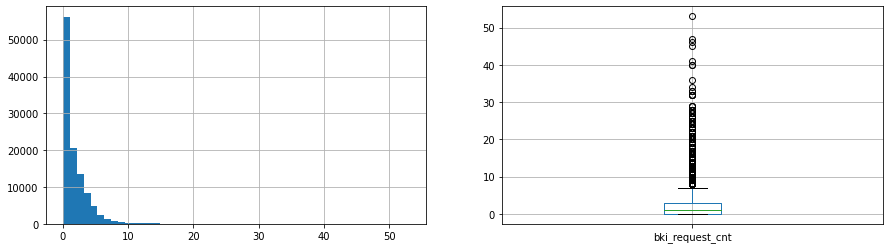

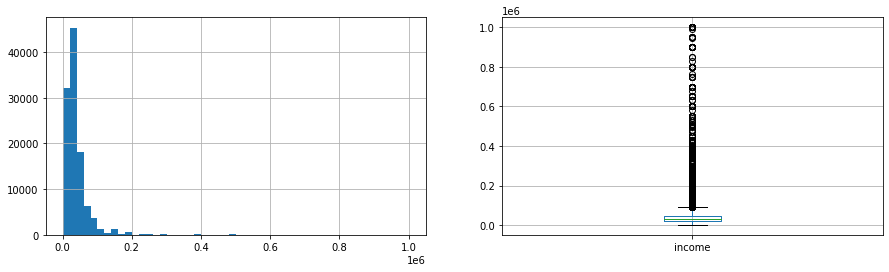

In [30]:
show_dists(df_num)

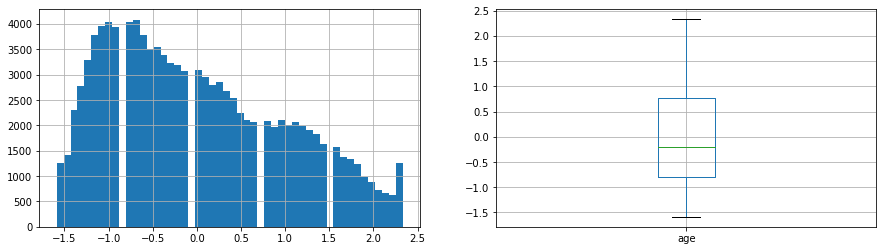

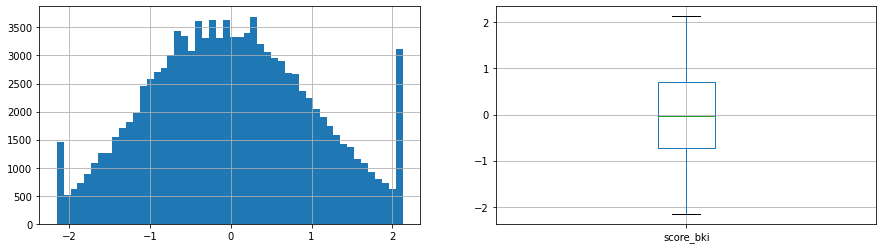

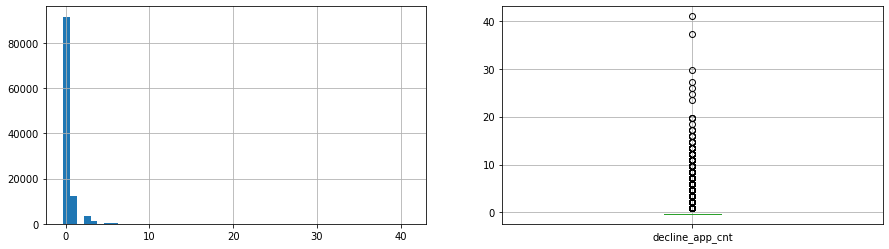

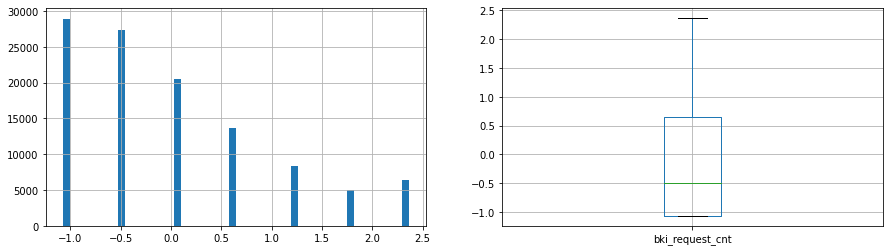

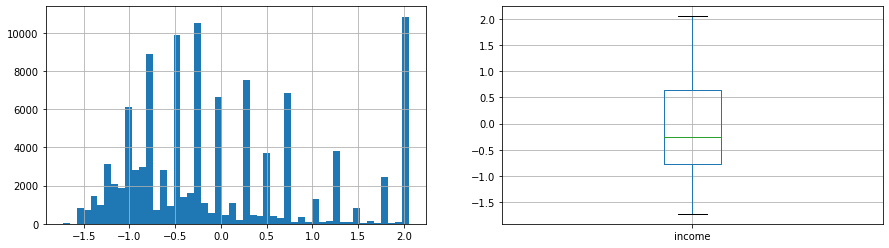

In [31]:
df_num2 = df_num.copy()

for column in df_num2.columns:
    if column not in ['decline_app_cnt']:
        ser = df_num2[column]
        Q1 = ser.quantile(0.25)
        Q3 = ser.quantile(0.75)
        IQR = Q3 -Q1
        df_num2[column] = np.maximum(np.minimum(ser, Q3 + IQR), Q1 - IQR)

df_num2[df_num2.columns] = preprocessing.StandardScaler().fit_transform(df_num2)
        
show_dists(df_num2)

In [32]:
Predictor([df_num2, df_cat, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

     ROC AUC       0.74


(0.5565610203606624, 0.7375179501816252)

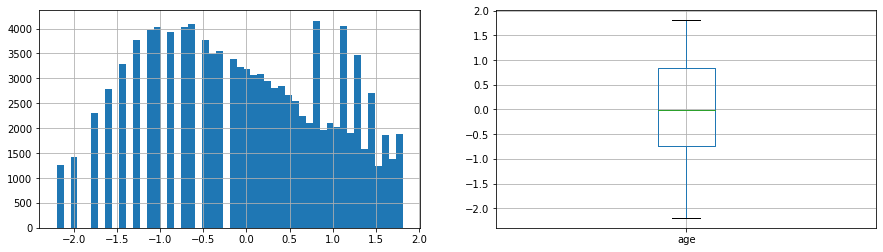

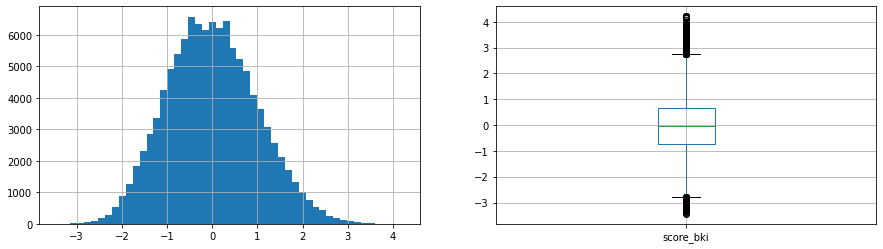

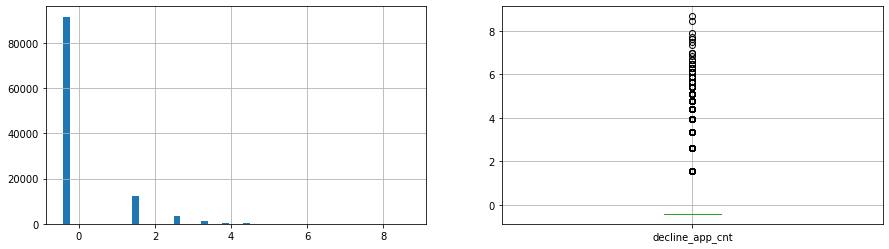

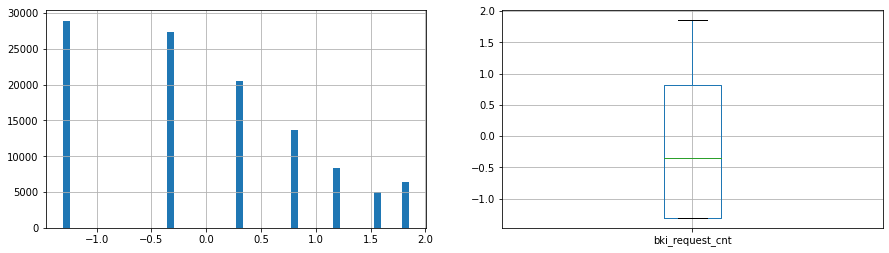

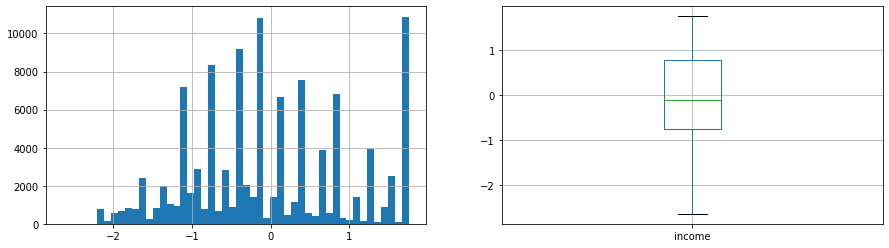

In [33]:
df_num3 = df_num.copy()

for column in df_num3.columns:
    if column not in ['score_bki']:
        ser = df_num2[column]
        df_num3[column] = np.log(ser - (ser.min() - 1.0))
        
df_num3[df_num3.columns] = preprocessing.StandardScaler().fit_transform(df_num3)
        
show_dists(df_num3)

In [34]:
Predictor([df_num3, df_cat, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

     ROC AUC       0.74


(0.5576436465594714, 0.7387123506433371)

<AxesSubplot:>

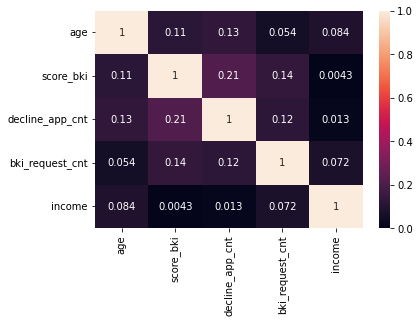

In [35]:
sns.heatmap(df_num3.corr().abs(), vmin=0, vmax=1, annot=True)

<AxesSubplot:>

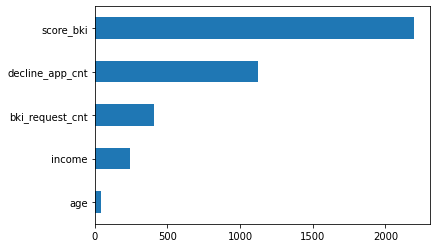

In [36]:
pd.Series(feature_selection.f_classif(df_num3, orig_data['default'])[0], index=df_num3.columns).sort_values().plot(kind='barh')

In [37]:
df_num4 = df_num3.copy()
df_num4.drop(['age'], axis=1, inplace=True)

Predictor([df_num4, df_cat, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

     ROC AUC       0.74


(0.5586773845966297, 0.7385079372697254)

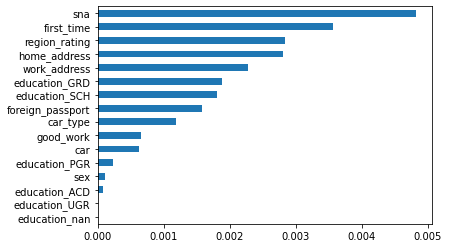

In [38]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', '`np.int` is a deprecated')
    pd.Series(
        feature_selection.mutual_info_classif(
            pd.concat([df_bin, df_cat], axis=1), 
            orig_data['default'], 
            discrete_features=True
        ), 
        index=list(df_bin.columns) + list(df_cat.columns)
    ).sort_values().plot(kind='barh')

In [39]:
df_cat2 = df_cat.copy()
df_cat2.drop(['education_nan'], axis=1, inplace=True)
df_cat2.drop(['education_UGR'], axis=1, inplace=True)
df_cat2.drop(['education_ACD'], axis=1, inplace=True)
Predictor([df_num4, df_cat2, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

     ROC AUC       0.74


(0.5586269196025293, 0.738543402778439)

In [40]:
df_bin2 = df_bin.copy()
df_bin2.drop(['sex'], axis=1, inplace=True)
Predictor([df_num4, df_cat2, df_bin2], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

     ROC AUC       0.73


(0.5566906964661642, 0.7345546757316168)

In [41]:
orig_data.groupby('education').default.mean().sort_values()

education
ACD    0.027491
PGR    0.043432
GRD    0.060544
UGR    0.087537
SCH    0.100900
Name: default, dtype: float64

In [42]:
orig_data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [43]:
df_cat3 = orig_data[cat_cols].copy()
mapping = {
    np.nan: 0,
    'SCH': 0,
    'UGR': 1,
    'GRD': 2,
    'PGR': 3,
    'ACD': 4
} 
df_cat3['education'] = pd.DataFrame(orig_data['education'].apply(mapping.get))

In [44]:
df_cat3['education'].value_counts(dropna=False)

0    58476
2    34768
1    14748
3     1865
4      291
Name: education, dtype: int64

In [45]:
Predictor([df_num4, df_cat3, df_bin], baseline_params).assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760

     ROC AUC       0.74


(0.5590224584153214, 0.7387035477485728)

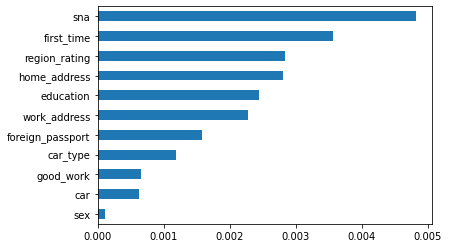

In [46]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', '`np.int` is a deprecated')
    pd.Series(
        feature_selection.mutual_info_classif(
            pd.concat([df_bin, df_cat3], axis=1), 
            orig_data['default'], 
            discrete_features=True
        ), 
        index=list(df_bin.columns) + list(df_cat3.columns)
    ).sort_values().plot(kind='barh')

In [47]:
df_final = pd.concat([df_num4, df_cat3, df_bin], axis=1)

In [48]:
df_final.sample(10)

,score_bki,decline_app_cnt,bki_request_cnt,income,education,first_time,sna,work_address,home_address,region_rating,sex,car,car_type,good_work,foreign_passport
65443,-0.191091,-0.422835,0.811609,0.164974,2,2,4,3,2,60,0,0,0,0,0
26963,-0.358601,-0.422835,-0.347862,-1.223159,0,4,1,3,2,40,0,0,0,0,0
56139,0.559046,2.622608,0.310198,-0.476756,0,3,1,2,1,50,1,0,0,0,0
89850,0.591041,-0.422835,-1.307360,-0.900431,0,2,3,2,1,60,1,1,1,1,0
27512,-0.339793,-0.422835,1.849733,-0.900431,0,3,1,3,2,40,0,0,0,0,1
96359,-1.316193,-0.422835,-1.307360,-0.751989,0,3,1,3,2,80,1,1,1,0,0
28311,0.561433,-0.422835,-1.307360,-0.751989,2,3,1,1,1,50,1,0,0,0,0
17337,-0.128869,-0.422835,1.216793,1.754753,2,4,1,3,2,80,1,1,1,0,1
16976,-0.047623,2.622608,-1.307360,-0.108704,1,1,4,2,1,60,1,0,0,0,0
94945,1.126243,-0.422835,1.556805,-0.751989,0,3,1,3,3,40,1,0,0,0,0


In [49]:
predictor = Predictor([df_final])
final_params = predictor.optimize_model_params(max_iter=1000, tol=1e-4)
print('\n'.join(f'{k:15s} {repr(v)}' for k, v in final_params.items()))

class_weight    'balanced'
max_iter        1000
multi_class     'auto'
penalty         'none'
solver          'saga'
tol             0.0001


In [50]:
predictor.assess()

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760

     ROC AUC       0.74


(0.5588710161243079, 0.7387125622513844)

In [51]:
predict_submission = predictor.final_predict()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:309: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [52]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [53]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.379268
std,31706.052195,0.485211
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [54]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /home/user/.kaggle. Or use the environment method.


# Выводы

- Перебор гиперпараметров даёт намного больший положительный эффект, чем мне удалось добиться работой с признаками.